# Graded Homework 1

Name: Vicente Conde Mendes

Acknowledgement of discussion with peers: Tobias Kiehntopf

## Part I: The Algorithm

### a) Conditional probability of spin value

The Hamiltonian of the system is:

$$ H(\mathbf{S}) = -\frac{1}{2N}\sum_{i, j}{S_i S_j} - h\sum_i{S_i}$$

We want the probability of a having a spin at $S_i = \pm 1$ given that all the other spins are fixed. This is the conditional probability:

$$ \mathbb{P}(S_i = \pm 1 | \{S_j\}_{j \neq i}) \equiv P_{\pm} = \frac{\mathbb{P}(S_i = \pm 1 \cap \{S_j\})}{\mathbb{P}(\{S_j\})}$$

The probability of a single configuration is given by the Boltzmann probability

$$ \mathbb{P}(\{S_i\}) = \frac{e^{-\beta H(\mathbf{\{S_i\}})}}{Z}$$

Where Z is the partition function:

$$Z = \sum_i{e^{-\beta H(\mathbf{\{S_i\}})}} $$

Therefore, the conditional probability $P_{\pm}$ is given by:

$$ P_{\pm} = \frac{e^{-\beta H(S_i = \pm 1 \cap \{S_j\})}}{e^{-\beta H(S_i = +1 \cap \{S_j\})} + e^{-\beta H(S_i = - 1 \cap \{S_j\})}}$$

The first step to simplify this expression is to identify common factors in the Hamiltonians that do not depend on $S_i$. We can write the Hamiltonian as:

$$ H(\mathbf{S}) = -\frac{1}{2N}(\sum_{j \neq i, k \neq i}{S_j S_k} + 2S_i\sum_{j\neq i}{S_j} + S_i^2) - h\sum_{j\neq i}{S_j} - hS_i$$

Now we group together all terms that do not depend on $S_i$ into a new function and use the fact that $S_i^2 = 1$ always.

$$ H(\mathbf{S}) = H'(S_j) - \frac{S_i\sum_{j\neq i}{S_j}}{N} - hS_i$$

And our probability becomes:

$$ P_{\pm} = \frac{e^{-\beta H'(S_j)}e^{\beta(S_i\frac{\sum_{j\neq i}{S_j}}{N} + hS_i) }}{e^{-\beta H'(S_j)}(e^{\beta(\frac{\sum_{j\neq i}{S_j}}{N} + h) }+e^{-\beta(\frac{\sum_{j\neq i}{S_j}}{N} + h) })}$$

Which simplifies to:

$$ P_{\pm} = \frac{e^{\pm\beta(\frac{\sum_{j\neq i}{S_j}}{N} + h) }}{2\cosh(\beta(\frac{\sum_{j\neq i}{S_j}}{N} + h))}$$


Which becomes, with some manipulation:

$$P_{\pm} = \frac{\cosh{\beta(\frac{\sum_{j\neq i}{S_j}}{N} + h)} \pm \sinh{\beta(\frac{\sum_{j\neq i}{S_j}}{N} + h)}}{2\cosh{\beta(\frac{\sum_{j\neq i}{S_j}}{N} + h)}} $$

$$ P_{\pm} = \frac{1 \pm \tanh(\beta(\frac{\sum_{j\neq i}{S_j}}{N} + h))}{2}$$

Finally, for N large enough, we can consider $\frac{\sum_{j\neq i}{S_j}}{N} = \bar{S}$, since depending on $S_i$ the value will only differ in $\frac{2}{N}$ and we get, as intended:

$$ P_{\pm} = \frac{1 \pm \tanh(\beta(\bar{S} + h))}{2}$$

### b) Implementing Glauber Dynamics

In [55]:
import numpy as np
import matplotlib.pyplot as plt

### Magnetization and Energy

First, we define functions to compute the magnetization and energy of a given configuration of spins

In [2]:
def compute_magnetization(s):
    # s: configuration of spins (array)
    return np.mean(s)

def compute_energy(s, h):
    # s: configuration of spins (array)
    # h: external field
    N = len(s)
    m = compute_magnetization(s)
    return -N*(1/2*m**2+h*m)

### Probability and Random Spin Choice

Then, we define spin_probability to calculate the probability $P_{\pm}$ we defined in the previous exercise. 

Finally, choose_spin will, given a configuration, choose a random spin and returns its index and value.

### 

In [3]:
def spin_probability(S_bar, beta, h, spin=1):
    # set spin to -1 if considering the probability of spin being -1
    return 1/2*(1+spin*np.tanh(beta*(S_bar+h)))

def choose_spin(s):
    #choose a random spin from configuration s, return its index and value
    idx = np.random.choice(s.size)
    return idx, s[idx]

### Glauber Dynamics

Finally we define the function which will execute the Glauber algorithm

###

In [13]:
def glauber_iteration(s_init, beta, h, tol = 1e-7):
    #s_init: starting configuration of spins
    #beta: 1/T
    #h: field
    #tol: tolerance criteria to reach convergence
    
    s = s_init
    N = len(s) #number of spins
    max_steps = 100*N #number of steps 
    
    m = compute_magnetization(s)
    E = compute_energy(s, h)

    magnetization = []
    energy = []

    for i in np.arange(max_steps):
        idx, spin = choose_spin(s) #choose a random spin

        r = np.random.uniform(0, 1) #draw a random number between 0 and 1
        if r < spin_probability(m, beta, h, spin=1): #compare with probability that spin is +1
            s[idx] = 1
        else:
            s[idx] = -1
        
        m = compute_magnetization(s)
        magnetization.append(m) #append new magnetization to list
        energy.append(compute_energy(s, h))

        #Uncomment if want to do convergence test
        #if (i % N == 0 and i > 0):
            #if (np.abs(magnetization[i]-magnetization[i-N]) < tol):
                #break
    
    return magnetization, energy





### Theoretical Prediction

Before we execute the Glauber algorithm, we will numerically solve the self-consistent equation of the Curie-Weiss model, with the parameters that will be used, to see what value of $m^*$ the algorithm should converge to.

In [77]:
def fixed_point_function(m, beta, h):
    return np.tanh(beta*(m+h))

def fixed_point_iter(beta, h, m_init=0.05, eta=0.8, tol=1e-6, maxIter = 1e5):
    m = m_init
    m_prev = m_init
    for _ in np.arange(maxIter):
        m_prev = m
        m = fixed_point_function(m, beta, h)*eta + (1-eta)*m_prev
        if np.abs(m-m_prev) < tol:
            break
    return m

print("For h = 0, the result is " + str(fixed_point_iter(1.2, 0, m_init=0.5)))
print("For h = -0.1, the result is " + str(fixed_point_iter(1.2, -0.1, m_init=-0.5)))

For h = 0, the result is 0.6585673417095848
For h = -0.1, the result is -0.7876278540089439


All cases with $\beta = 1.2$

So, we expect to get, for $h = 0$, something around $m = 0.66$ (there should be the other possibility at $m = -0.66$, but since we will start with all $S_i = 1$, I expect the algorithm to converge to the positive one.)

For $h = -0.1$, we expect to get around $m = -0.79$.

### Glauber Dynamics for $h = 0$, $\beta = 1.2$

We execute the Glauber algorithm for a starting configuration of all spins $S_i = 1$, $h = 0$ and $\beta = 1.2$. We compare different values of $N = 10, 50, 100, 200, 1000$ and iterate through $t = 100N$ steps

We plot the evolution of the magnetization for the different N values. We plot two horizontal green dashed lines at the theoretical expected $m^*$ values.

/var/folders/vg/b1j027cd3vjcqjtbx_ggb3p40000gn/T/ipykernel_70330/1501375476.py:5: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.5)
/var/folders/vg/b1j027cd3vjcqjtbx_ggb3p40000gn/T/ipykernel_70330/1501375476.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.5)


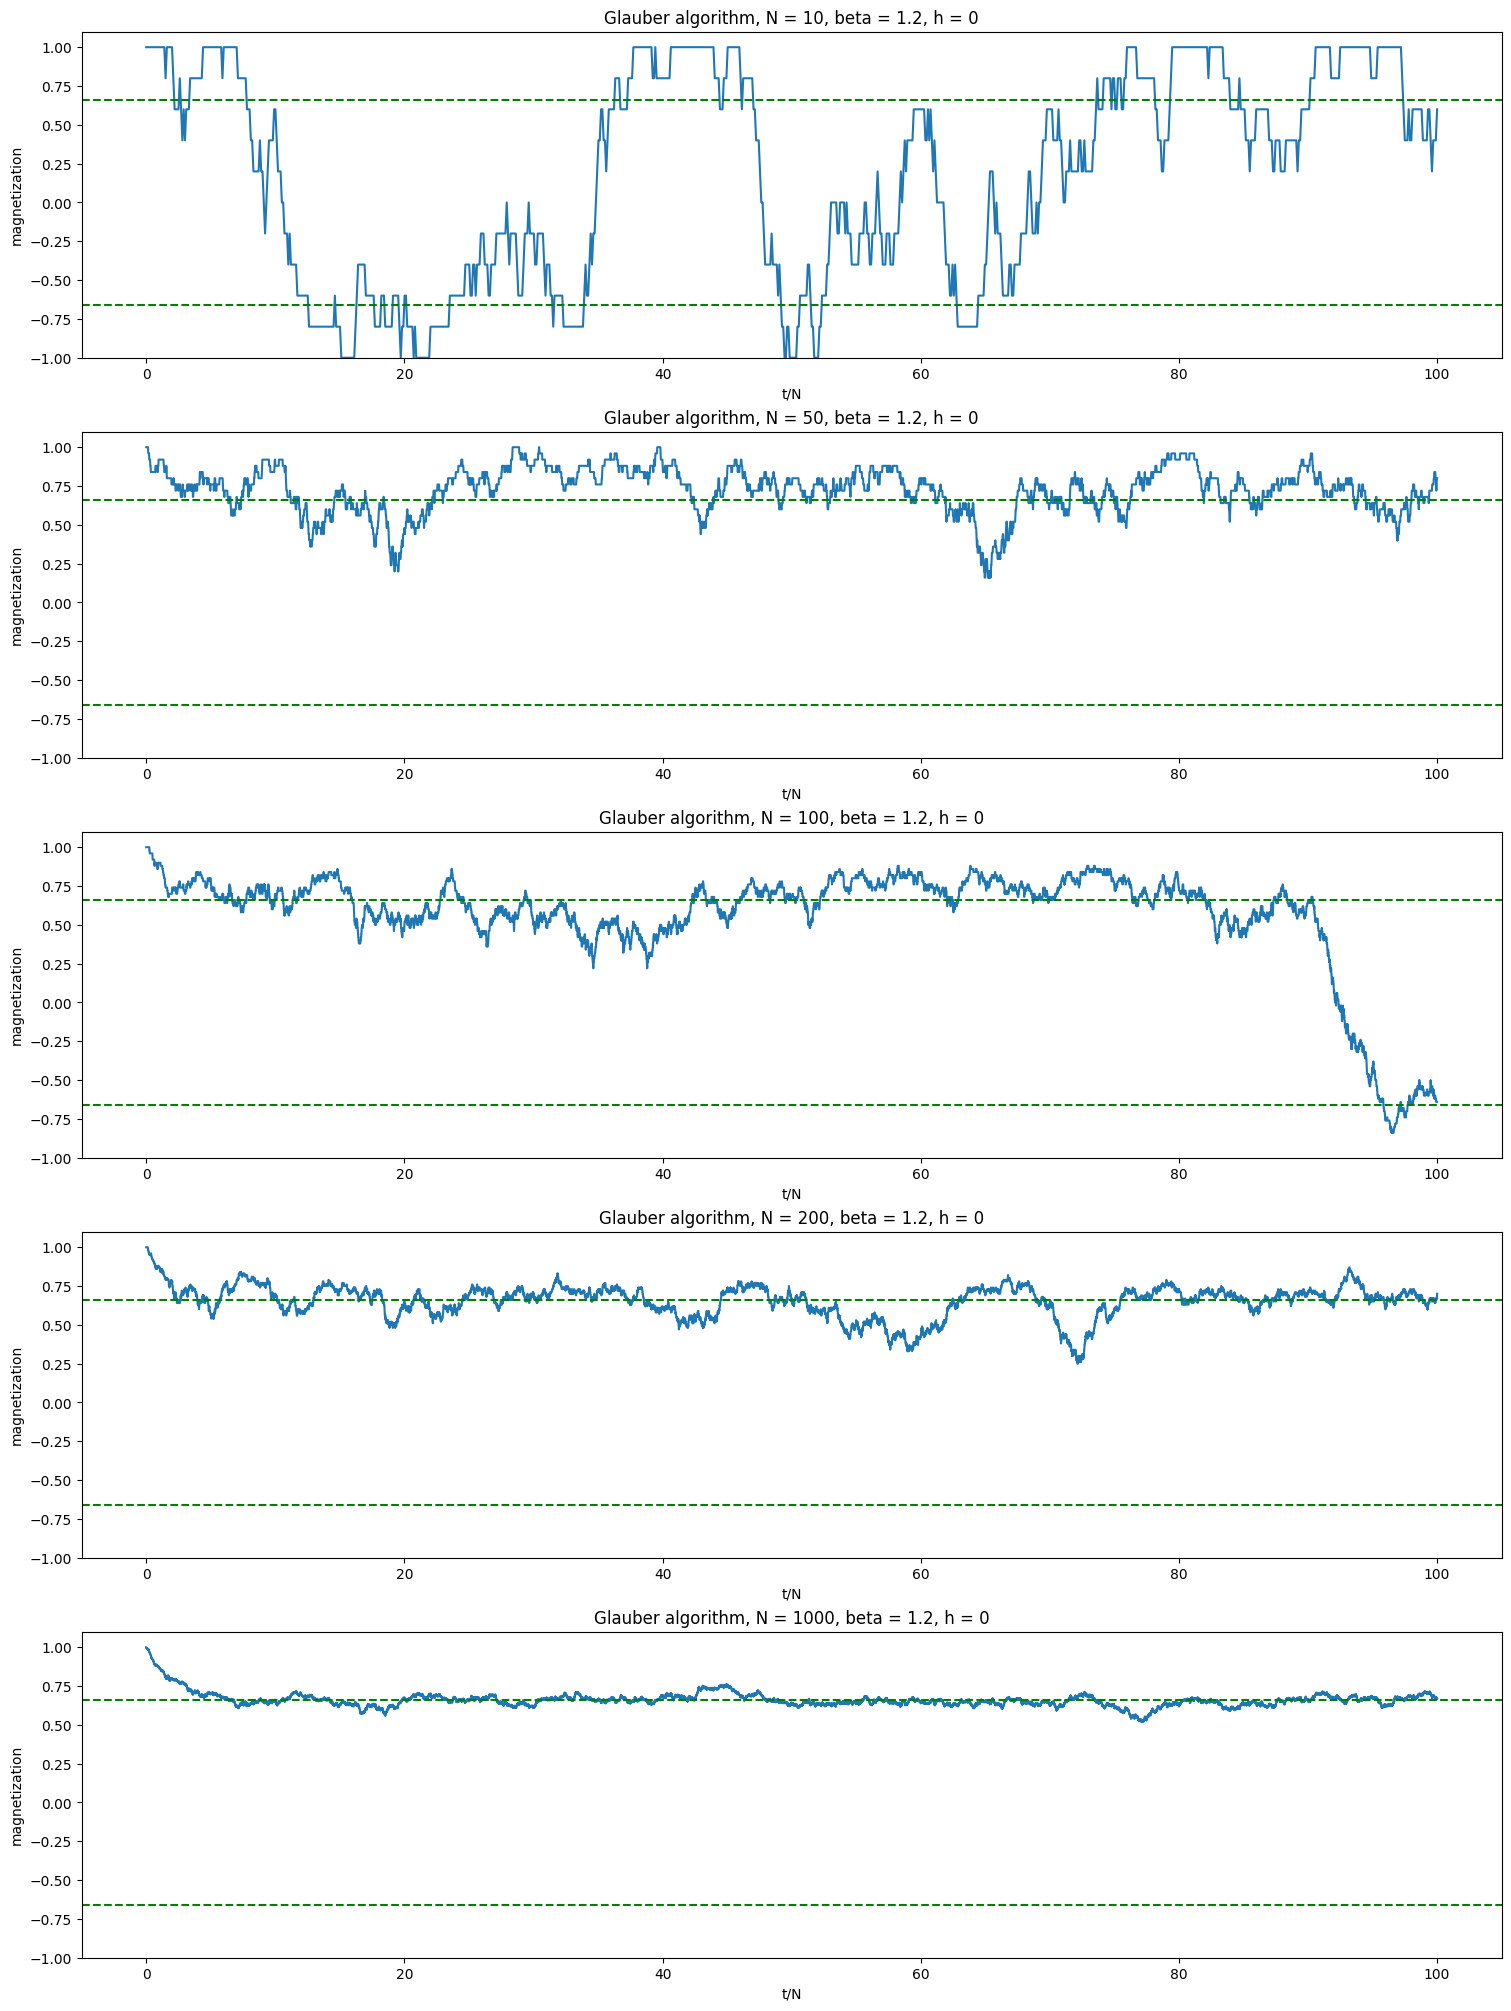

In [87]:
N_list = [10, 50, 100, 200, 1000]

fig, axs = plt.subplots(5, 1, layout='constrained')
fig.set_size_inches(15, 20)
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.5)

for N, ax in zip(N_list, axs.flatten()):
    s_init = np.ones(N)

    magnetization, energy = glauber_iteration(s_init, beta=1.2, h=0)

    time_space = np.linspace(0, 100, num=len(magnetization))
    ax.plot(time_space, magnetization, label = 'N = ' + str(N))
    ax.axhline(y = 0.659, color = 'g', linestyle = '--') 
    ax.axhline(y = -0.659, color = 'g', linestyle = '--')
    ax.set(xlabel='t/N', ylabel = 'magnetization', title="Glauber algorithm, N = " + str(N) + ", beta = 1.2, h = 0" )
    ax.set_ylim([-1,1.1])

plt.show()


### Remarks

A few interesting observations:

* The bigger the N, the more clear and stable is the convergence of the algorithm;
* The algorithm converges around the expected value of $m^*$, with a few oscillations;
* Interestingly, sometimes, especially for smaller values of N, the algorithm can "jump" from one fixed point to the other, negative one. For long enough time, given that the two are both global maximums of the free entropy, the algorithm might be jumping from one to the other.


# Glauber Dynamics for $h = -0.1$, $\beta = 1.2$

We execute the Glauber algorithm for a starting configuration of all spins $S_i = 1$, but this time $h = -0.1$ and $\beta = 1.2$. We compare different values of $N = 10, 50, 100, 200, 1000$ and iterate throguh $t = 100N$ steps

We plot the evolution of the magnetization for the different N values. We plot one horizontal green dashed line at the theoretical expected $m^*$ value.

/var/folders/vg/b1j027cd3vjcqjtbx_ggb3p40000gn/T/ipykernel_70330/2549734507.py:5: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.5)
/var/folders/vg/b1j027cd3vjcqjtbx_ggb3p40000gn/T/ipykernel_70330/2549734507.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.5)


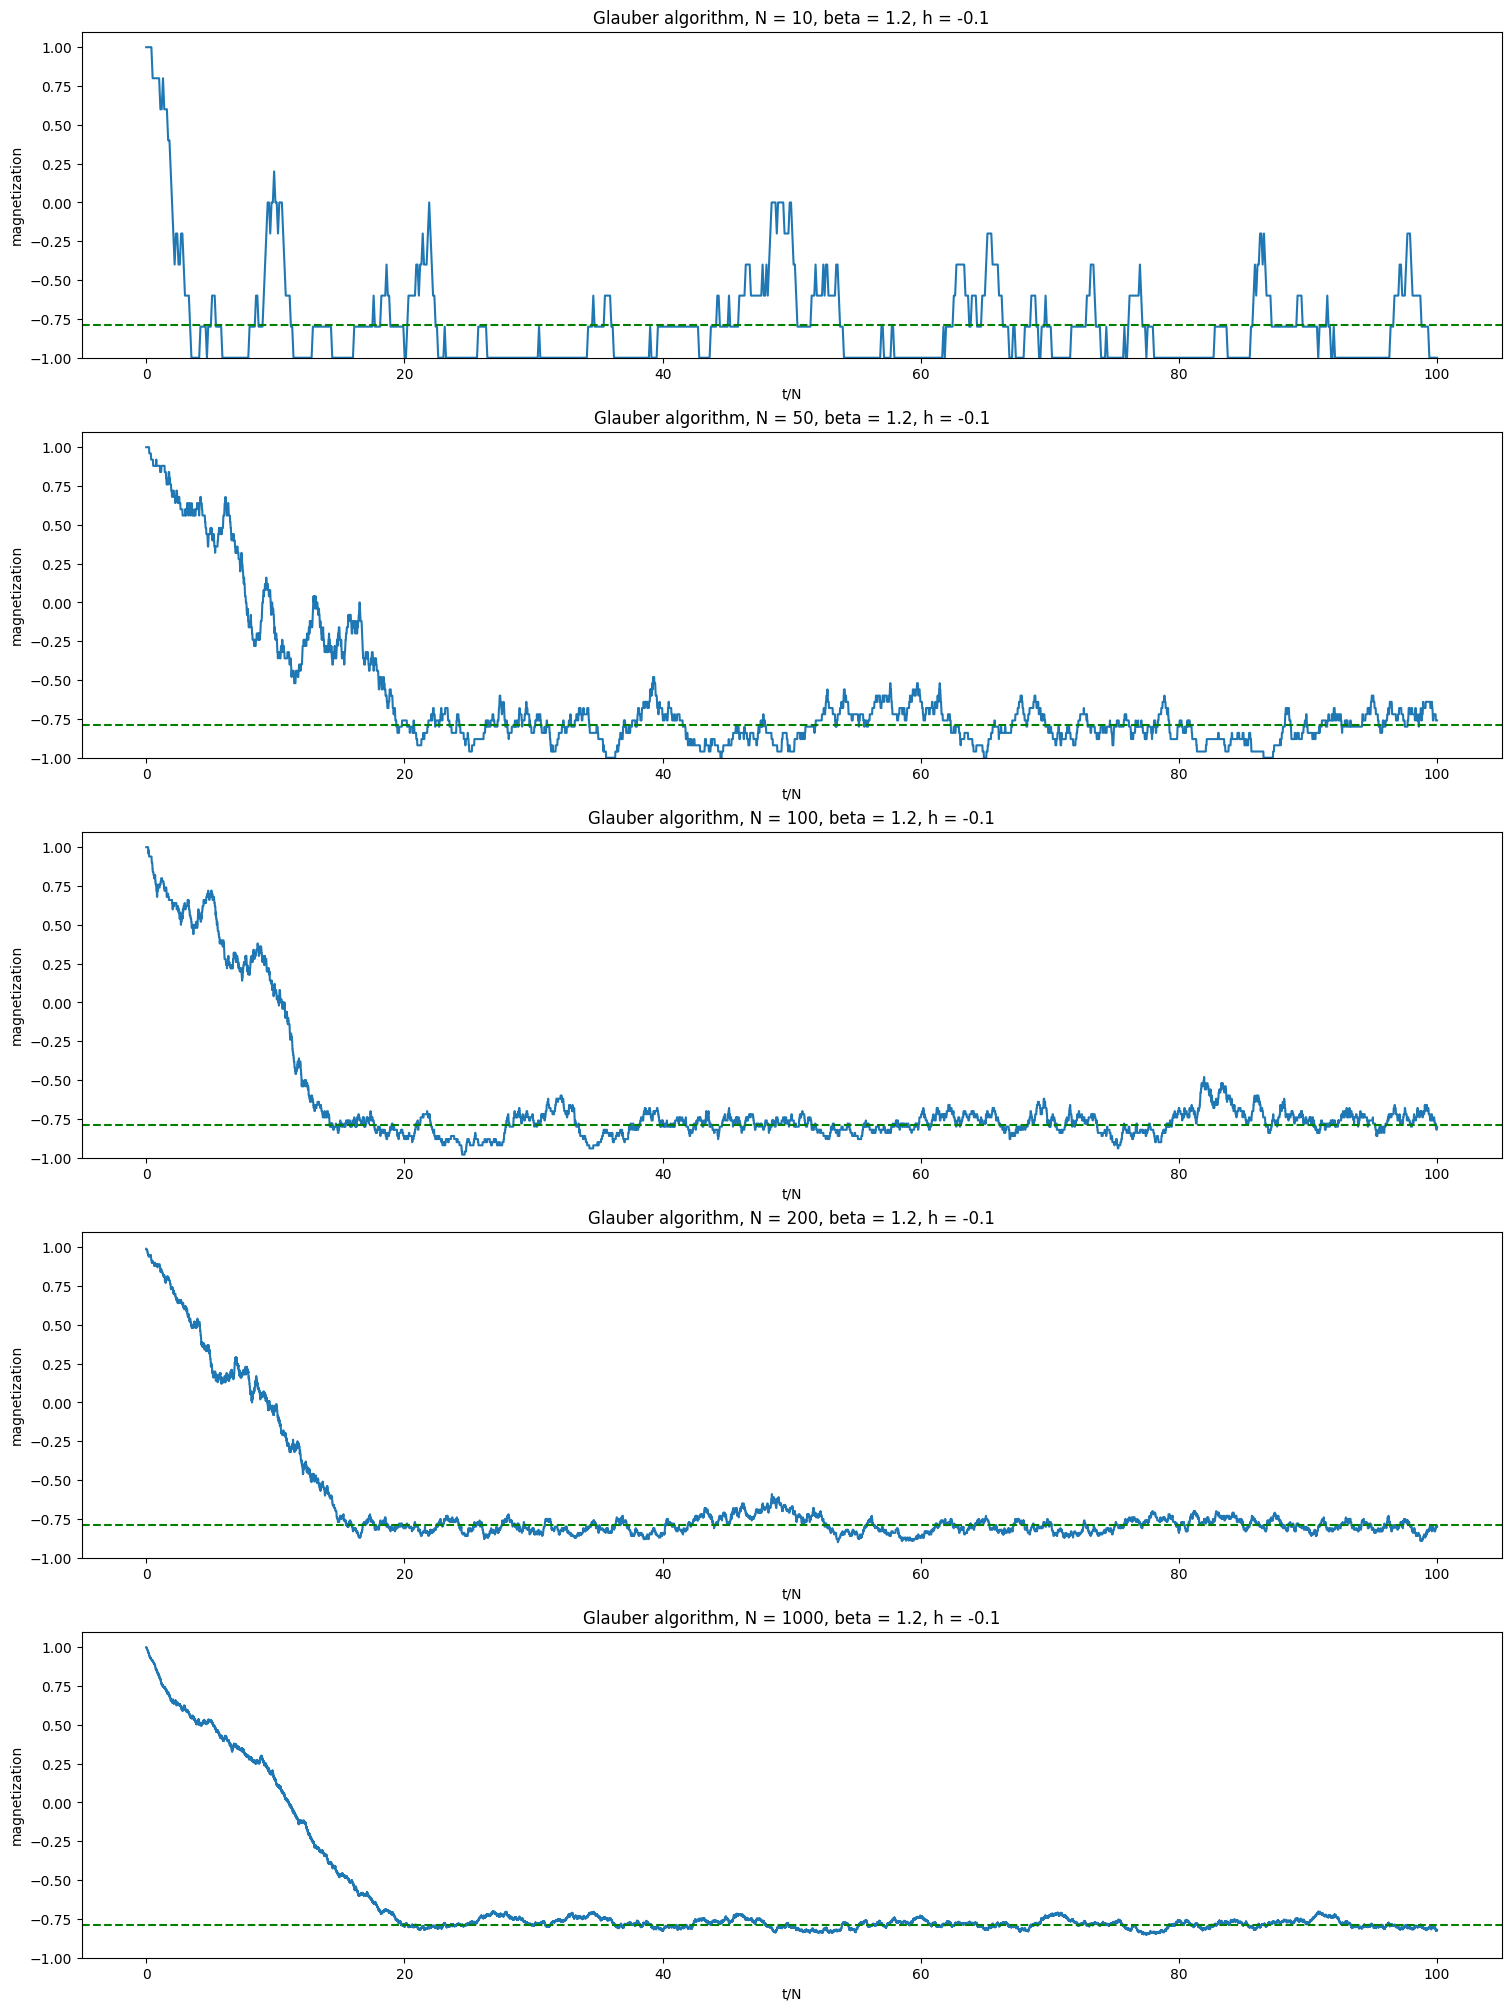

In [89]:
N_list = [10, 50, 100, 200, 1000]

fig, axs = plt.subplots(5, 1, layout='constrained')
fig.set_size_inches(15, 20)
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.5)

for N, ax in zip(N_list, axs.flatten()):
    s_init = np.ones(N)

    magnetization, energy = glauber_iteration(s_init, beta=1.2, h=-0.1)

    time_space = np.linspace(0, 100, num=len(magnetization))
    ax.plot(time_space, magnetization, label = 'N = ' + str(N))
    ax.axhline(y = -0.788, color = 'g', linestyle = '--')
    ax.set(xlabel='t/N', ylabel = 'magnetization', title="Glauber algorithm, N = " + str(N) + ", beta = 1.2, h = -0.1" )
    ax.set_ylim([-1,1.1])

plt.show()


### Remarks

* Similarly, the bigger the N, the more clear and stable is the convergence of the algorithm;
* The algorithm converges around the expected value of $m^*$, with a few oscillations, smaller for bigger N;
* Now that there is a small negative field, there is only one global maximum at $m^* = -0.788$. Even starting with all $S_i = 1$, the algorithm converges to this global maximum. There are no more jumps.

# Part II: Mean-Field Equations from Glauber

## (a) 

Let $m_t$ denote the total magnetisation at time t, and define $P_{t,m} = P(m_t = m)$. For simplicity, consider $\beta = 1$ and $h = 0$. Let $\delta$ be a timestep. 

Let $N^+$ be the number of positive spins and $N^-$ the number of negative spins. Then, given a magnetization m, we have the following relations:

$$ N^+ + N^- = N$$

$$ N^+ - N^- = mN $$

Which imply that:

$$ N^+ = \frac{1+m}{2}N$$ 

When choosing a random spin, the probability that we draw a positive spin given a magnetization m is, then:

$$ P^+ = \frac{N^+}{N} = \frac{1+m}{2} $$

and, for choosing a negative spin:

$$ P^- = 1 - P_+ = \frac{1-m}{2} $$

Then, after a timestep $\delta$, there are 4 possibilities:
* We chose a positive spin ($P^+$) and kept it that way; ($P_+$)
* We chose a positive spin ($P^+$) and changed it to negative; ($P_-$)
* We chose a negative spin ($P^-$) and kept it that way; ($P_-$)
* We chose a negative spin ($P^-$) and changed it to positive. ($P_+$)

This can be directly reflected in a master equation, using these probabilities and $P_{\pm}$ from the first exercise with the correct values of $m$ for each case:

$$P_{t+\delta, m} = P_{t, m+\frac{2}{N}} \frac{1+m+\frac{2}{N}}{2} \frac{1-tanh(m+2/N)}{2} + P_{t, m-\frac{2}{N}} \frac{1-m+\frac{2}{N}}{2} \frac{1+tanh(m-2/N)}{2} + P_{t, m} \frac{1+m}{2} \frac{1+tanh(m)}{2} + P_{t, m} \frac{1-m}{2} \frac{1-tanh(m)}{2} $$

Which is just

$$P_{t+\delta, m} = P_{t, m+\frac{2}{N}} \frac{1+m+\frac{2}{N}}{2} \frac{1-tanh(m+2/N)}{2} + P_{t, m-\frac{2}{N}} \frac{1-m+\frac{2}{N}}{2} \frac{1+tanh(m-2/N)}{2} + P_{t, m} \times (\frac{1+m}{2} \frac{1+tanh(m)}{2} + \frac{1-m}{2} \frac{1-tanh(m)}{2} )$$

## (b)

Defining the mean magnetisation with respect to $P_{t,m}$

$$ <m(t)> = \int dm  m P_{t,m} $$

Plugging in the master equation above, we get directly for the expected
magnetisation:

$$<m(t+\delta)> = \int P_{t, m+\frac{2}{N}} \frac{1+m+\frac{2}{N}}{2} \frac{1-tanh(m+2/N)}{2} \times m dm + \int P_{t, m-\frac{2}{N}} \frac{1-m+\frac{2}{N}}{2} \frac{1+tanh(m-2/N)}{2} \times m dm + \int P_{t, m} \times (\frac{1+m}{2} \frac{1+tanh(m)}{2} + \frac{1-m}{2} \frac{1-tanh(m)}{2} ) \times m dm $$


## (c)

Making the change of variables $m \to m-2/N$ in the first integral and $m \to m + 2/N$ in the second, we get (the differential stays the same):

$$<m(t+\delta)> = \int P_{t, m} \frac{1+m}{2} \frac{1-tanh(m)}{2} \times (m-2/N) dm + \int P_{t, m} \frac{1-m}{2} \frac{1+tanh(m)}{2} \times (m+2/N) dm + \int P_{t, m} \times (\frac{1+m}{2} \frac{1+tanh(m)}{2} + \frac{1-m}{2} \frac{1-tanh(m)}{2} ) \times m dm $$ 

Simplifying:

$$<m(t+\delta)> = \int P_{t, m} dm (\frac{1+m}{2}m+\frac{1-m}{2}m+\frac{2}{N}(\frac{1-m}{2}\frac{1+tanh(m)}{2}-\frac{1+m}{2}\frac{1-tanh(m)}{2})) $$ 

$$<m(t+\delta)> = \int P_{t, m} dm (m + \frac{tanh(m)-m}{N}) = <m(t)> + \frac{<tanh(m)> - <m>}{N}$$

$$\frac{<m(t+\delta)> - <m(t)>}{\delta}  =  \frac{<tanh(m)> - <m>}{N\delta}$$

Then, if $\delta = \frac{1}{N}$ and $N \to \inf$

$$ \frac{d<m(t)>}{dt} = <tanh(m(t))> - <m(t)>$$



## (d)

If the expected magnetisation is stationary, then $ \frac{d<m(t)>}{dt}  = 0$. If we can assume $<tanh(m(t))> \approx  tanh<m(t)>$, then we can write:

$$ <m(t)> = tanh<m(t)> $$

Which is precisely the Curie-Weiss self-consistent equation for $\beta = 1$ and $h=0$!

## (e) Solving ODE

We begin my integrating the ODE using scipy.integrate and comparing the solution with the Glauber Dynamics we found previously.

In [15]:
from scipy.integrate import solve_ivp

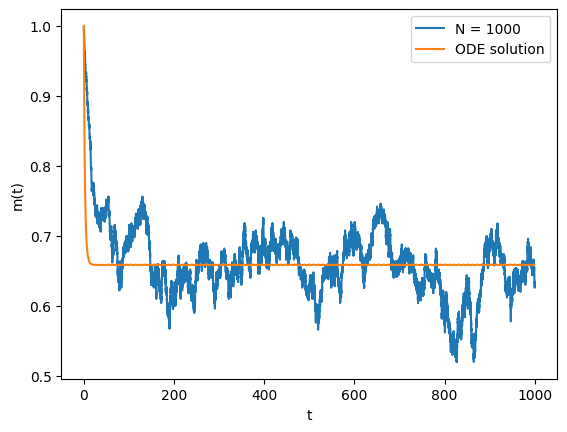

In [131]:
beta = 1.2
h = 0
F = lambda t, m: np.tanh(beta*(m+h)) - m #Defining the function to be integrated

t_eval = np.arange(0, 1000, 1) 
sol = solve_ivp(F, [0, 1000], [1], t_eval=t_eval)

s_init = np.ones(1000)
magnetization, energy = glauber_iteration(s_init, beta=1.2, h=0)
time_space = np.linspace(0, 1000, num=len(magnetization))
plt.plot(time_space, magnetization, label = 'N = 1000')

plt.plot(sol.t, sol.y[0], label = 'ODE solution')
plt.xlabel('t')
plt.ylabel('m(t)')
plt.legend()
plt.show()

### Remarks

* The ODE converges to the same value, as expected, but with much less oscillations.

## Different values of $h$ and $\beta$

Now we use this ODE method to solve the mean field equation for different values of h and beta

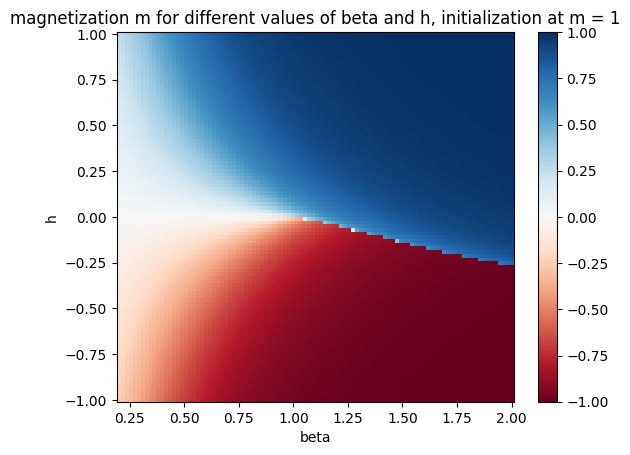

In [133]:
F = lambda t, m, beta, h: np.tanh(beta*(m+h)) - m

beta_space = np.linspace(0.2, 2, num=100)
h_space = np.linspace(-1, 1, num=100)

magnetization = np.zeros(shape=(100, 100))

for idx, h in enumerate(h_space):
    for idb, beta in enumerate(beta_space):
        t_eval = np.arange(0, 100, 0.1)
        sol = solve_ivp(F, [0, 100], [1], t_eval=t_eval, args=(beta, h))
        magnetization[idx][idb] = sol.y[0][-1]

mesh = plt.pcolormesh(beta_space, h_space, magnetization, cmap='RdBu')
plt.colorbar(mesh)
plt.clim(-1, 1)  # Set the color limits to match your data range
plt.xlabel('beta')
plt.ylabel('h')
plt.title('magnetization m for different values of beta and h, initialization at m = 1')
plt.show()

### Remarks

* Some sanity checks: for positive h, magnetization is positive; for negative h, magnetization is negative;
* We can clearly see the phase transition happening along the $\beta$ axis. Once $\beta$ grows (T gets lower) past a critical point (beta = 1), the symmetry breaking happens and, even at h close to 0, a magnetization exists.
* However, the system should be symmetric in h, and starting from the critical point the plot is no longer symmetric in h. This happens because the ODE solver is being trapped in a spurious maxima of the free entropy. A good way to see this is to make the same plot but giving m the initial value of -1. It should give a mirrored plot.

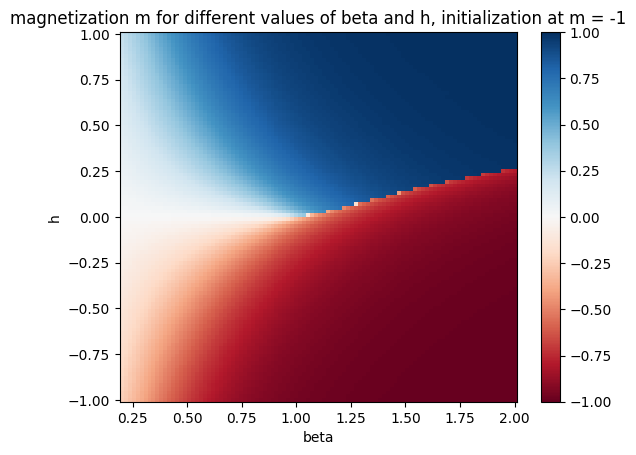

In [132]:
F = lambda t, m, beta, h: np.tanh(beta*(m+h)) - m

beta_space = np.linspace(0.2, 2, num=100)
h_space = np.linspace(-1, 1, num=100)

magnetization = np.zeros(shape=(100, 100))

for idx, h in enumerate(h_space):
    for idb, beta in enumerate(beta_space):
        t_eval = np.arange(0, 100, 0.1)
        sol = solve_ivp(F, [0, 100], [-1], t_eval=t_eval, args=(beta, h))
        magnetization[idx][idb] = sol.y[0][-1]

mesh = plt.pcolormesh(beta_space, h_space, magnetization, cmap='RdBu')
plt.colorbar(mesh)
plt.clim(-1, 1)  # Set the color limits to match your data range
plt.xlabel('beta')
plt.ylabel('h')
plt.title('magnetization m for different values of beta and h, initialization at m = -1')
plt.show()

## Remarks

* This plot is the reflection of the previous one on the x axis, as expected. Therefore, the region where the ODE solver is being trapped in a spurious maxima of the free entropy is the one that changes between the two plots.
* Finally, we can try initializing near m = 0 to get a better picture.

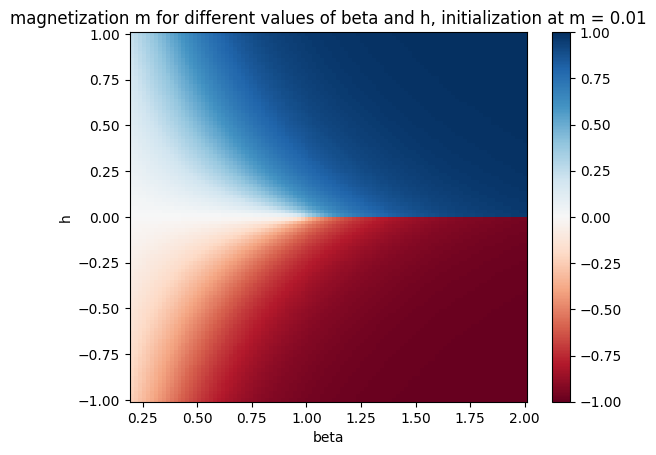

In [124]:
F = lambda t, m, beta, h: np.tanh(beta*(m+h)) - m

beta_space = np.linspace(0.2, 2, num=100)
h_space = np.linspace(-1, 1, num=100)

magnetization = np.zeros(shape=(100, 100))

for idx, h in enumerate(h_space):
    for idb, beta in enumerate(beta_space):
        t_eval = np.arange(0, 100, 0.1)
        sol = solve_ivp(F, [0, 100], [0.01], t_eval=t_eval, args=(beta, h))
        magnetization[idx][idb] = sol.y[0][-1]

mesh = plt.pcolormesh(beta_space, h_space, magnetization, cmap='RdBu')
plt.colorbar(mesh)
plt.clim(-1, 1)  # Set the color limits to match your data range
plt.xlabel('beta')
plt.ylabel('h')
plt.title('magnetization m for different values of beta and h, initialization at m = 0.01')
plt.show()

## Remarks

* Now the plot is symmetric on the h axis, as it should. In this case, it works fine. However, it is important to note that it is possible that initializing near 0 will also find spurious maxima at m = 0, for systems where they exist. In the Curie-Weiss model, since the phase transition is always a first order one, once m = 0 stops being a global maximum of the free entropy, it stops being a maximum at all and becomes a minimum. Therefore, there is no problem initializing near 0.